In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats as st

In [2]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 15, 8
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'
rcParams['font.size'] = '16'

In [3]:
df_real = pd.read_csv('E-Commerce Shipping Data.csv')

In [6]:
df_real.tail()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0
10998,10999,D,Ship,2,5,155,5,low,F,6,1639,0


# Rename reach on time to `is_shipping_late`

In [7]:
df = df_real.copy()
df.rename(columns={'Reached.on.Time_Y.N':'is_shipping_late'}, inplace=True)

In [8]:
numerical = ['Customer_care_calls', 'Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms']
categorical = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_rating', 
               'Prior_purchases', 'Product_importance', 'Gender', 'is_shipping_late']

# Target dari dataset

- Reached.on.Time_Y.N

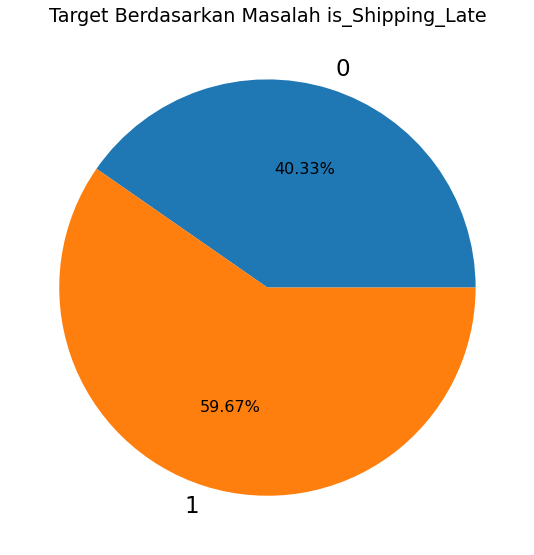

In [9]:
delay=pd.DataFrame(df.groupby(['is_shipping_late'])['ID'].count()/len(df)).reset_index()
plt.pie(delay['ID'],labels=delay['is_shipping_late'],autopct='%1.2f%%')
plt.title('Target Berdasarkan Masalah is_Shipping_Late')

plt.tight_layout()

# Missing Data

In [10]:
df.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
is_shipping_late       0
dtype: int64

- Tidak terdapat missing value pada data

# Duplicated Data

In [11]:
df.duplicated().sum()

0

- Tidak terdapat data yang duplicate

# Feature Encoding

## Label Encoding

In [12]:
# buat mappingan per kategori dan di replace ke masing2 kolom
mapping_Importance = {
    'low' : 0,
    'medium' : 1,
    'high' : 2
}

df['Product_importance_labeled'] = df['Product_importance'].map(mapping_Importance)

## One Hot Encoding

In [13]:
oh_Warehouse_block = pd.get_dummies(df.Warehouse_block, prefix='Warehouse_block')
oh_Gender = pd.get_dummies(df.Gender, prefix='Gender')
oh_Mode_of_Shipment = pd.get_dummies(df.Mode_of_Shipment, prefix='Mode_of_Shipment')

In [14]:
df = df.join([oh_Warehouse_block, oh_Gender, oh_Mode_of_Shipment])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          10999 non-null  int64 
 1   Warehouse_block             10999 non-null  object
 2   Mode_of_Shipment            10999 non-null  object
 3   Customer_care_calls         10999 non-null  int64 
 4   Customer_rating             10999 non-null  int64 
 5   Cost_of_the_Product         10999 non-null  int64 
 6   Prior_purchases             10999 non-null  int64 
 7   Product_importance          10999 non-null  object
 8   Gender                      10999 non-null  object
 9   Discount_offered            10999 non-null  int64 
 10  Weight_in_gms               10999 non-null  int64 
 11  is_shipping_late            10999 non-null  int64 
 12  Product_importance_labeled  10999 non-null  int64 
 13  Warehouse_block_A           10999 non-null  ui

# Identifikasi Outlier

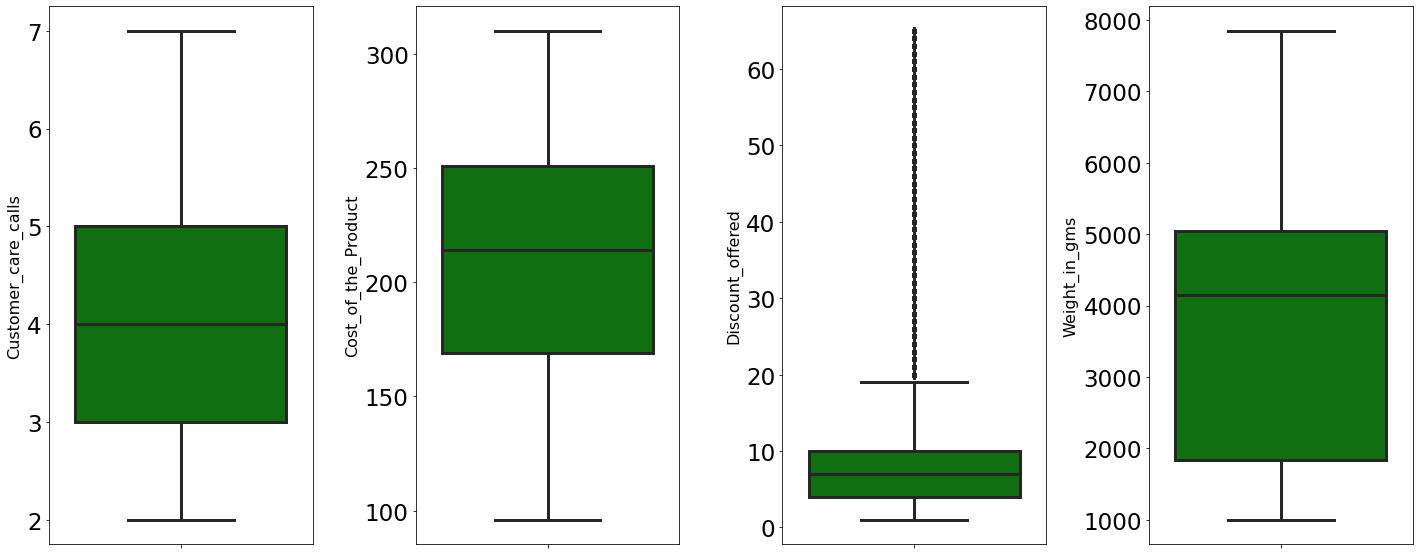

In [16]:
# Identikasi outlier dengan boxplot
plt.figure(figsize=(20,8))
for i in range(0,len(numerical)):
    plt.subplot(1, len(numerical), i+1)
    sns.boxplot(y=df[numerical[i]], color='green')
    plt.tight_layout()

In [17]:
# Identifikasi outlier dengan IQR
for col in numerical:
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    nilai_min = df[col].min()
    nilai_max = df[col].max()
    lower_lim = Q1 - (1.5*IQR)
    upper_lim = Q3 + (1.5*IQR)
    

    if (nilai_min < lower_lim):
        print('Low outlier is found in column',col,'<', lower_lim,'\n')
        #display total low outlier 
        print('Total of Low Outlier in column',col, ':', len(list(df[df[col] < lower_lim].index)),'\n')
    elif (nilai_max > upper_lim):
        print('High outlier is found in column',col,'>', upper_lim,'\n')
        #display total high outlier 
        print('Total of High Outlier in column',col, ':', len(list(df[df[col] > upper_lim].index)),'\n')
        
    else:
        print('Outlier is not found in column',col,'\n')

Outlier is not found in column Customer_care_calls 

Outlier is not found in column Cost_of_the_Product 

High outlier is found in column Discount_offered > 19.0 

Total of High Outlier in column Discount_offered : 2209 

Outlier is not found in column Weight_in_gms 



- Terdapat outlier di kolom Discount_offered sebanyak 2209 yang hampir 30% data

# Imbalanced Dataset

In [18]:
df['Reached'] = df['is_shipping_late'] > 0.8
df['Reached'].value_counts()

True     6563
False    4436
Name: Reached, dtype: int64

- Tidak terdapat perbedaan yang signifikan antar data, sehingga bisa dibilang data cukup seimbang

# Handling Log Transformation

In [19]:
df['Discount_offered_log'] = np.log(df['Discount_offered'])

In [20]:
df['Discount_offered_oh1'] = df['Discount_offered']

In [21]:
for col in ['Discount_offered_oh1']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (IQR * 1.5)
    upper_bound = Q3 + (IQR * 1.5)

    df[col] = np.where(df[col] >= upper_bound,
                         upper_bound, df[col])
    df[col] = np.where(df[col] <= lower_bound,
                         lower_bound, df[col])

In [22]:
hanya_labeling = ['Customer_care_calls', 'Customer_rating',
                  'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms',
                  'Product_importance_labeled', 'Warehouse_block_A', 'Warehouse_block_B',
                  'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F', 'Gender_F',
                  'Gender_M', 'Mode_of_Shipment_Flight','Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship',
                  'is_shipping_late']
dengan_oh1 = ['Customer_care_calls', 'Customer_rating',
                  'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered_oh1', 'Weight_in_gms',
                  'Product_importance_labeled', 'Warehouse_block_A', 'Warehouse_block_B',
                  'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F', 'Gender_F',
                  'Gender_M', 'Mode_of_Shipment_Flight','Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship',
                  'is_shipping_late']
dengan_log = ['Customer_care_calls', 'Customer_rating',
                  'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered_log', 'Weight_in_gms',
                  'Product_importance_labeled', 'Warehouse_block_A', 'Warehouse_block_B',
                  'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F', 'Gender_F',
                  'Gender_M', 'Mode_of_Shipment_Flight','Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship',
                  'is_shipping_late']

In [23]:
# hanya labelling
df_a = df[hanya_labeling]
df_a.info()
df_a.to_csv('only_label.csv', index_label=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Customer_care_calls         10999 non-null  int64
 1   Customer_rating             10999 non-null  int64
 2   Cost_of_the_Product         10999 non-null  int64
 3   Prior_purchases             10999 non-null  int64
 4   Discount_offered            10999 non-null  int64
 5   Weight_in_gms               10999 non-null  int64
 6   Product_importance_labeled  10999 non-null  int64
 7   Warehouse_block_A           10999 non-null  uint8
 8   Warehouse_block_B           10999 non-null  uint8
 9   Warehouse_block_C           10999 non-null  uint8
 10  Warehouse_block_D           10999 non-null  uint8
 11  Warehouse_block_F           10999 non-null  uint8
 12  Gender_F                    10999 non-null  uint8
 13  Gender_M                    10999 non-null  uint8
 14  Mode_o

In [24]:
# hanya labelling + dengan outliers handling
df_b = df[dengan_oh1]
df_b.info()
df_b.to_csv('dengan_oh1.csv', index_label=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_care_calls         10999 non-null  int64  
 1   Customer_rating             10999 non-null  int64  
 2   Cost_of_the_Product         10999 non-null  int64  
 3   Prior_purchases             10999 non-null  int64  
 4   Discount_offered_oh1        10999 non-null  float64
 5   Weight_in_gms               10999 non-null  int64  
 6   Product_importance_labeled  10999 non-null  int64  
 7   Warehouse_block_A           10999 non-null  uint8  
 8   Warehouse_block_B           10999 non-null  uint8  
 9   Warehouse_block_C           10999 non-null  uint8  
 10  Warehouse_block_D           10999 non-null  uint8  
 11  Warehouse_block_F           10999 non-null  uint8  
 12  Gender_F                    10999 non-null  uint8  
 13  Gender_M                    109

In [25]:
# hanya labelling + Discount_offered_log 
df_c = df[dengan_log]
df_c.info()
df_c.to_csv('dengan_log.csv', index_label=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_care_calls         10999 non-null  int64  
 1   Customer_rating             10999 non-null  int64  
 2   Cost_of_the_Product         10999 non-null  int64  
 3   Prior_purchases             10999 non-null  int64  
 4   Discount_offered_log        10999 non-null  float64
 5   Weight_in_gms               10999 non-null  int64  
 6   Product_importance_labeled  10999 non-null  int64  
 7   Warehouse_block_A           10999 non-null  uint8  
 8   Warehouse_block_B           10999 non-null  uint8  
 9   Warehouse_block_C           10999 non-null  uint8  
 10  Warehouse_block_D           10999 non-null  uint8  
 11  Warehouse_block_F           10999 non-null  uint8  
 12  Gender_F                    10999 non-null  uint8  
 13  Gender_M                    109

In [26]:
df.is_shipping_late

0        1
1        1
2        1
3        1
4        1
        ..
10994    1
10995    0
10996    0
10997    0
10998    0
Name: is_shipping_late, Length: 10999, dtype: int64

In [27]:
df_b

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered_oh1,Weight_in_gms,Product_importance_labeled,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Gender_F,Gender_M,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,is_shipping_late
0,4,2,177,3,19.0,1233,0,0,0,0,1,0,1,0,1,0,0,1
1,4,5,216,2,19.0,3088,0,0,0,0,0,1,0,1,1,0,0,1
2,2,2,183,4,19.0,3374,0,1,0,0,0,0,0,1,1,0,0,1
3,3,3,176,4,10.0,1177,1,0,1,0,0,0,0,1,1,0,0,1
4,2,2,184,3,19.0,2484,1,0,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,4,1,252,5,1.0,1538,1,1,0,0,0,0,1,0,0,0,1,1
10995,4,1,232,5,6.0,1247,1,0,1,0,0,0,1,0,0,0,1,0
10996,5,4,242,5,4.0,1155,0,0,0,1,0,0,1,0,0,0,1,0
10997,5,2,223,6,2.0,1210,1,0,0,0,0,1,0,1,0,0,1,0


# Random Forest Classification

In [28]:
#df_a

# Split Train Test Data
from sklearn.model_selection import train_test_split

X = df_a.drop(columns=['is_shipping_late'])
y = df_a['is_shipping_late']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

# Fit & Predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)
print("Accuracy (Test Set Data A): %.2f" % accuracy_score(y_test, y_pred))

Accuracy (Test Set Data A): 0.67


In [29]:
#df_b

# Split Train Test Data
from sklearn.model_selection import train_test_split

X = df_b.drop(columns=['is_shipping_late'])
y = df_b['is_shipping_late']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

# Fit & Predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)
print("Accuracy (Test Set Data B): %.2f" % accuracy_score(y_test, y_pred))

Accuracy (Test Set Data B): 0.67


In [30]:
#df_c

# Split Train Test Data
from sklearn.model_selection import train_test_split

X = df_c.drop(columns=['is_shipping_late'])
y = df_c['is_shipping_late']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

# Fit & Predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)
print("Accuracy (Test Set Data C): %.2f" % accuracy_score(y_test, y_pred))

Accuracy (Test Set Data C): 0.67


# Hyperparameter Tuning

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

n_estimators = [5,20,50,100] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split

hyperparameters = dict(n_estimators=n_estimators,
                       max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features
                      )

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, hyperparameters, n_iter = 100, cv=5, random_state=42, scoring='accuracy')
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [1, 4, 8, 12, 16, 19, 23,
                                                      27, 31, 34, 38, 42, 46,
                                                      49, 53, 57, 61, 64, 68,
                                                      72, 76, 79, 83, 87, 91,
                                                      94, 98, 102, 106, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10, 20,
                                                             50],
                                        'min_samples_split': [2, 5, 10, 100],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=42, scoring='accuracy')

# Print the best parameters

In [32]:
print ('Random grid: ', hyperparameters, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_depth': [1, 4, 8, 12, 16, 19, 23, 27, 31, 34, 38, 42, 46, 49, 53, 57, 61, 64, 68, 72, 76, 79, 83, 87, 91, 94, 98, 102, 106, 110], 'min_samples_split': [2, 5, 10, 100], 'min_samples_leaf': [1, 2, 4, 10, 20, 50], 'max_features': ['auto', 'sqrt']} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 100, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 34}  



# Using best parameter

In [33]:
randmf = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, min_samples_leaf= 4, max_features = 'sqrt', max_depth= 34) 
randmf.fit(X_train, y_train) 

RandomForestClassifier(max_depth=34, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=100)

In [34]:
y_pred_best=randmf.predict(X_test)
print("Accuracy (Best): %.2f" % accuracy_score(y_test, y_pred))

Accuracy (Best): 0.67


Text(0.5, 1.0, 'feature importance score')

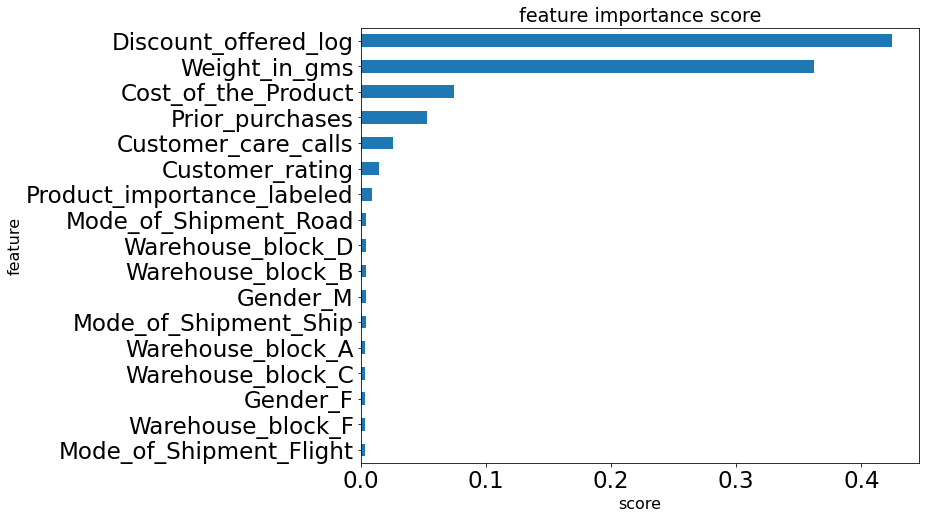

In [35]:
feat_importances = pd.Series(randmf.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')